In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/Friday-16-02-2018_TrafficForML_CICFlowMeter.csv
/kaggle/input/Thursday-15-02-2018_TrafficForML_CICFlowMeter.csv
/kaggle/input/Wednesday-14-02-2018_TrafficForML_CICFlowMeter.csv
/kaggle/input/Friday-02-03-2018_TrafficForML_CICFlowMeter.csv
/kaggle/input/Thursday-22-02-2018_TrafficForML_CICFlowMeter.csv
/kaggle/input/Wednesday-21-02-2018_TrafficForML_CICFlowMeter.csv
/kaggle/input/Thuesday-20-02-2018_TrafficForML_CICFlowMeter.csv
/kaggle/input/Friday-23-02-2018_TrafficForML_CICFlowMeter.csv
/kaggle/input/Thursday-01-03-2018_TrafficForML_CICFlowMeter.csv
/kaggle/input/Wednesday-28-02-2018_TrafficForML_CICFlowMeter.csv


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
import lime.lime_tabular
import shap
from tqdm import tqdm

2024-11-27 10:35:15.349211: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-27 10:35:15.349327: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-27 10:35:15.524588: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Loading Data**:
It loads a dataset from a CSV file using pandas.


In [3]:
# Load data
df = pd.read_csv('/kaggle/input/Wednesday-14-02-2018_TrafficForML_CICFlowMeter.csv')
print(f'Instances: {df.shape[0]}')
print(f'Features: {df.shape[1]}')

Instances: 1048575
Features: 80


In [4]:
df.head()

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,14/02/2018 08:31:01,112641719,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320859.5,139.300036,56320958,56320761,Benign
1,0,0,14/02/2018 08:33:50,112641466,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320733.0,114.551299,56320814,56320652,Benign
2,0,0,14/02/2018 08:36:39,112638623,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56319311.5,301.934596,56319525,56319098,Benign
3,22,6,14/02/2018 08:40:13,6453966,15,10,1239,2273,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
4,22,6,14/02/2018 08:40:23,8804066,14,11,1143,2209,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign


In [5]:
df.tail()

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
1048570,80,6,14/02/2018 10:53:23,10156986,5,5,1089,1923,587,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
1048571,80,6,14/02/2018 10:53:33,117,2,0,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
1048572,80,6,14/02/2018 10:53:28,5095331,3,1,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
1048573,80,6,14/02/2018 10:53:28,5235511,3,1,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,Benign
1048574,443,6,14/02/2018 10:53:28,5807256,6,4,327,145,245,0,...,20,291569.0,0.0,291569,291569,5515650.0,0.0,5515650,5515650,Benign


In [6]:
df.isnull().sum()

Dst Port         0
Protocol         0
Timestamp        0
Flow Duration    0
Tot Fwd Pkts     0
                ..
Idle Mean        0
Idle Std         0
Idle Max         0
Idle Min         0
Label            0
Length: 80, dtype: int64

# **Data Preprocessing**:
   - Drops unnecessary columns from the dataset.
   - Encodes categorical labels using LabelEncoder.
   - Removes rows with NaN or infinite values.

In [7]:
df1 = df.drop(df.columns[:3], axis=1)
df1.shape

(1048575, 77)

In [8]:
df1['Label'].unique()

array(['Benign', 'FTP-BruteForce', 'SSH-Bruteforce'], dtype=object)

In [9]:
df1 = df1[~df1['Label'].str.contains('Label')]
df1.shape

(1048575, 77)

Label
Benign            667626
FTP-BruteForce    193360
SSH-Bruteforce    187589
Name: count, dtype: int64

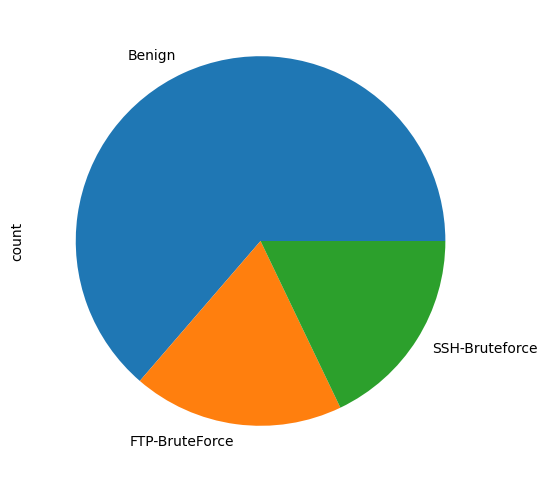

In [10]:
Labels_in_df = df1['Label'].unique()
df1['Label'].value_counts().plot(kind='pie',figsize=(6,6))
df1['Label'].value_counts()

In [11]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df1['Label'] = label_encoder.fit_transform(df1['Label'].values.ravel())
df1['Label'].unique()

array([0, 1, 2])

In [12]:
pd.options.mode.chained_assignment = None
df1.replace([np.inf, -np.inf], np.nan, inplace=True)
df1 = df1.dropna()
print('dropping NaN and Inf values, if any')
print(f'Shape after cleaning: {df1.shape}')

dropping NaN and Inf values, if any
Shape after cleaning: (1044751, 77)


In [13]:
# Preparing data for modeling
X = df1.drop('Label', axis=1).values
y = df1['Label'].values

In [14]:
# Split the data before feature selection
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=52, shuffle=True)

# **Feature Selection**: 


In [15]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

class Beluga:
    def __init__(self, num_features):
        self.position = np.random.choice([0, 1], size=num_features)
        self.fitness = float('inf')

def fitness(X_train, y_train, X_test, y_test, selected_features):
    selected_indices = np.where(selected_features)[0]
    
    if len(selected_indices) == 0:
        return float('inf')  # Penalize for selecting no features
    
    clf = RandomForestClassifier(random_state=42)
    clf.fit(X_train[:, selected_indices], y_train)
    y_pred = clf.predict(X_test[:, selected_indices])
    return 1 - accuracy_score(y_test, y_pred)

def beluga_whale_optimization(X_train, y_train, X_test, y_test, num_belugas=10, max_iter=10):
    num_features = X_train.shape[1]
    belugas = [Beluga(num_features) for _ in range(num_belugas)]
    global_best_position = np.zeros(num_features)
    global_best_fitness = float('inf')

    for iteration in range(max_iter):
        a = 2 - iteration * (2 / max_iter)  # Linearly decreasing parameter
        for beluga in tqdm(belugas, desc=f"Iteration {iteration+1}/{max_iter}"):
            r1 = np.random.rand()
            r2 = np.random.rand()
            A = 2 * a * r1 - a  # Similar to WOA's encircling prey
            C = 2 * r2  # Similar to WOA's bubble-net behavior
            
            # Choose a strategy based on beluga social behavior
            if np.random.rand() < 0.5:
                # Social cooperation: Beluga whales work together
                D = np.abs(C * global_best_position - beluga.position)
                new_position = global_best_position - A * D
            else:
                # Exploration: Individual beluga randomly searches
                D = np.abs(C * beluga.position - np.random.choice(belugas).position)
                new_position = beluga.position + A * D

            # Apply new position
            beluga.position = np.clip(new_position, 0, 1).astype(int)

            # Evaluate fitness
            beluga.fitness = fitness(X_train, y_train, X_test, y_test, beluga.position)

            # Update global best position
            if beluga.fitness < global_best_fitness:
                global_best_position = beluga.position
                global_best_fitness = beluga.fitness

    return global_best_position

# Apply BWO algorithm to select features
selected_features = beluga_whale_optimization(X_train, y_train, X_test, y_test, num_belugas=10, max_iter=2)
selected_indices = np.where(selected_features)[0]
X_train_selected = X_train[:, selected_indices]
X_test_selected = X_test[:, selected_indices]
print("Selected features:", selected_indices)


Iteration 2/2: 100%|██████████| 10/10 [00:57<00:00,  5.71s/it]


Selected features: [ 0  1  5 12 13 14 15 17 18 19 20 25 26 29 31 36 37 40 42 44 46 47 49 50
 51 53 54 55 56 57 58 59 60 61 62 64 65 67 70 75]


# **Scaling Features**:
It scales the selected features using RobustScaler.

In [16]:
from sklearn.preprocessing import RobustScaler

# Scaling the selected features
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_selected)
X_test_scaled = scaler.transform(X_test_selected)


5. **Reshaping Data for RNN-Bi lstm**: It reshapes the data for compatibility with a Recurrent Neural Network (RNN) model.

In [17]:
# Reshape for the model
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, 1, X_train_scaled.shape[1])
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, 1, X_test_scaled.shape[1])
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

In [18]:
print("Original shapes:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

print("\nShapes after feature selection and scaling:")
print("X_train_scaled:", X_train_scaled.shape)
print("X_test_scaled:", X_test_scaled.shape)

print("\nShapes after reshaping for RNN:")
print("X_train_reshaped:", X_train_reshaped.shape)
print("X_test_reshaped:", X_test_reshaped.shape)


Original shapes:
X_train: (835800, 76)
X_test: (208951, 76)
y_train: (835800,)
y_test: (208951,)

Shapes after feature selection and scaling:
X_train_scaled: (835800, 40)
X_test_scaled: (208951, 40)

Shapes after reshaping for RNN:
X_train_reshaped: (835800, 1, 1, 40)
X_test_reshaped: (208951, 1, 1, 40)


**Defining and Training an RNN Bi Lstm Model**: 


In [19]:
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder, RobustScaler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import SimpleRNN, Dense

# # Define RNN model
# model = Sequential()
# model.add(SimpleRNN(units=64, input_shape=(X_train_scaled.shape[1], 1))) 
# model.add(Dense(32, activation='relu'))
# model.add(Dense(16, activation='relu'))
# model.add(Dense(3, activation='softmax'))  

# # Compile the model
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# # Train the model
# history=model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

In [20]:
from keras.utils import to_categorical

# Encode labels
y_train_encoded = to_categorical(y_train, num_classes=10)  # Adjust 'num_classes' to your actual number of classes
y_test_encoded = to_categorical(y_test, num_classes=10)



In [21]:
# Import necessary libraries
from keras.layers import Dense, SimpleRNN, Bidirectional, LSTM
from keras.models import Sequential
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np

# Example Data Preparation (Assume X, y are your features and labels)
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features using RobustScaler
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the data for the RNN model (3D input required for RNNs)
X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], 1, X_train_scaled.shape[1])
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], 1, X_test_scaled.shape[1])

# Convert labels to categorical (Assuming classification task)
num_classes = len(np.unique(y_train))
y_train_encoded = to_categorical(y_train, num_classes=num_classes)
y_test_encoded = to_categorical(y_test, num_classes=num_classes)

# Define the RNN model
model = Sequential()
model.add(SimpleRNN(units=64, return_sequences=True, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
model.add(Bidirectional(LSTM(units=64)))  # BiLSTM layer
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))  # Output layer for classification

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_reshaped, y_train_encoded, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

# Evaluate the model using reshaped test data
loss, accuracy = model.evaluate(X_test_reshaped, y_test_encoded, verbose=0)
print(f'Test Accuracy: {accuracy}')


Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Epoch 1/10
20895/20895 ━━━━━━━━━━━━━━━━━━━━ 145s 7ms/step - accuracy: 0.9982 - loss: 0.0118 - val_accuracy: 0.9999 - val_loss: 4.6220e-04
Epoch 2/10
20895/20895 ━━━━━━━━━━━━━━━━━━━━ 141s 7ms/step - accuracy: 0.9999 - loss: 6.8828e-04 - val_accuracy: 0.9999 - val_loss: 7.7760e-04
Epoch 3/10
20895/20895 ━━━━━━━━━━━━━━━━━━━━ 141s 7ms/step - accuracy: 0.9999 - loss: 6.8274e-04 - val_accuracy: 0.9999 - val_loss: 4.6504e-04
Epoch 4/10
20895/20895 ━━━━━━━━━━━━━━━━━━━━ 142s 7ms/step - accuracy: 0.9999 - loss: 6.0200e-04 - val_accuracy: 0.9999 - val_loss: 4.1993e-04
Epoch 5/10
20895/20895 ━━━━━━━━━━━━━━━━━━━━ 142s 7ms/step - accuracy: 0.9999 - loss: 6.6554e-04 - val_accuracy: 1.0000 - val_loss: 3.7829e-04
Epoch 6/10
20895/20895 ━━━━━━━━━━━━━━━━━━━━ 142s 7ms/step - accuracy: 1.0000 - loss: 5.2520e-04 - val_accuracy: 0.9999 - val_loss: 5.5567e-04
Epoch 7/10
20895/20895 ━━━━━━━━━━━━━━━━━━━━ 142s 7ms/step - accuracy: 0.9999 - loss: 6.2369e-04 - val_accuracy: 1.0000 - val_loss: 3.8101e-04
Epoch 8/10

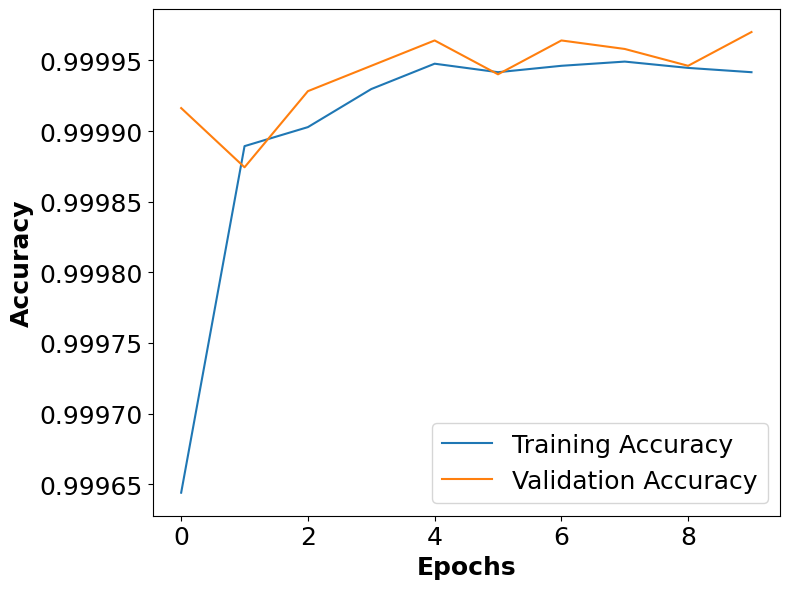

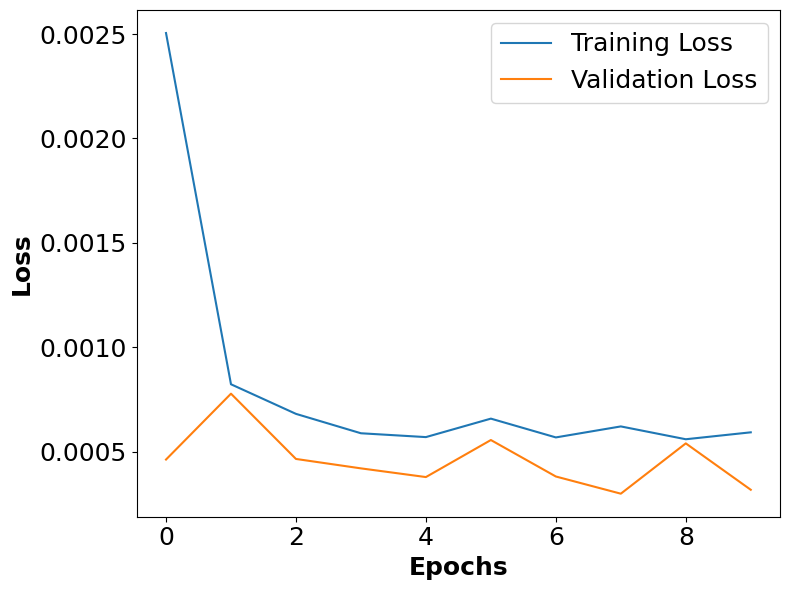

In [22]:
import matplotlib.pyplot as plt
# Plotting epoch versus accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Epoch vs Accuracy',weight='bold')
plt.xlabel('Epochs',weight='bold',fontsize=18)
plt.ylabel('Accuracy',weight='bold',fontsize=18)
plt.xticks(np.arange(0, len(history.history['accuracy']), step=2)) 
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)

plt.tight_layout()
plt.show()

# Plotting epoch versus loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Epoch vs Loss',weight='bold')
plt.xlabel('Epochs',weight='bold',fontsize=18)
plt.ylabel('Loss',weight='bold',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)

plt.tight_layout()
plt.show()

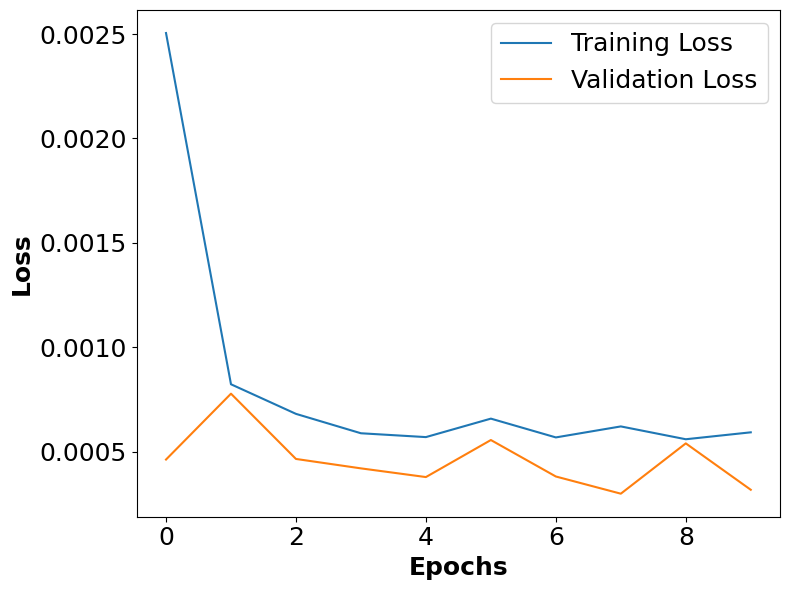

In [23]:
# Plotting epoch versus loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Epoch vs Loss',weight='bold')
plt.xlabel('Epochs',weight='bold',fontsize=18)
plt.ylabel('Loss',weight='bold',fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=18)

plt.tight_layout()
plt.show()

In [24]:
# Flatten the data for the classifier
X_train_flat = X_train_reshaped.squeeze()
X_test_flat = X_test_reshaped.squeeze()
y_train_flat = np.argmax(y_train_categorical, axis=1)
y_test_flat = np.argmax(y_test_categorical, axis=1)

In [25]:
import numpy as np

# Assuming y_test_flat contains your target variable
num_classes = len(np.unique(y_test_flat))
print("Number of classes:", num_classes)


Number of classes: 3


In [ ]:
# from sklearn.metrics import classification_report
# import numpy as np

# # Reshape the test data to match model input shape
# X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# # Predict on test data
# y_pred_prob = model.predict(X_test_scaled)
# y_pred = np.argmax(y_pred_prob, axis=1)

# # Print classification report
# print(classification_report(y_test, y_pred,digits=6))


# Model Evaluation:
It evaluates the trained model on the test data and prints the test accuracy,classification report and confusion matrix

In [40]:
from sklearn.metrics import classification_report
# Predict on test data
y_pred_prob = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1)

# Print classification report
print(classification_report(y_test, y_pred,digits=4))



6530/6530 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000    132745
           1     0.9997    1.0000    0.9999     38753
           2     1.0000    0.9997    0.9999     37453

    accuracy                         0.9999    208951
   macro avg     0.9999    0.9999    0.9999    208951
weighted avg     0.9999    0.9999    0.9999    208951



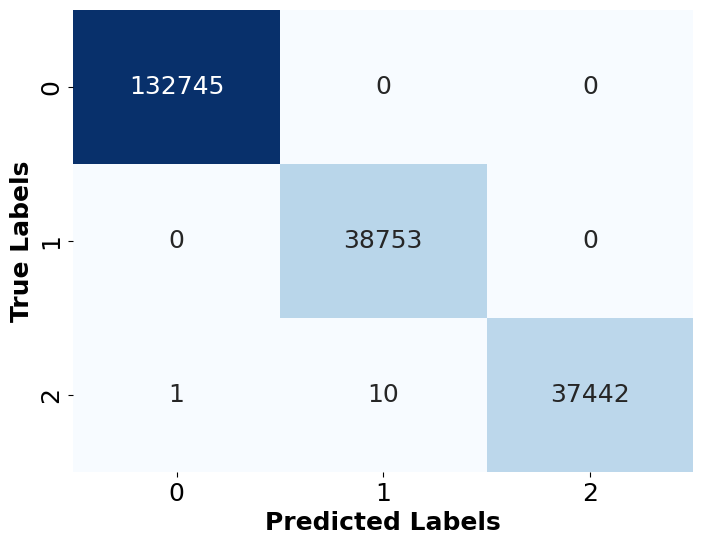

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 18})
# plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels',fontsize=18,weight='bold')
plt.ylabel('True Labels',fontsize=18,weight='bold')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

6530/6530 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step


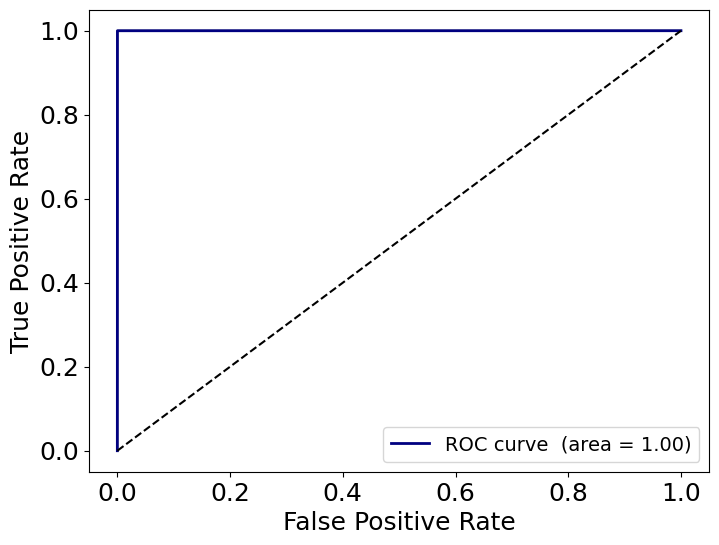

In [39]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt

# Convert y_test and y_pred to one-hot encoded format
y_test_binary = label_binarize(y_test, classes=np.unique(y_test))
y_pred_prob = model.predict(X_test_scaled)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(np.unique(y_test))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binary[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binary.ravel(), y_pred_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color='gray', alpha=0.4)  # No labels for individual classes

plt.plot(fpr["micro"], tpr["micro"], color='navy',  linewidth=2, 
         label=f'ROC curve  (area = {roc_auc["micro"]:0.2f})')

plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
# plt.title('ROC Curve for Multiclass Classification')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(loc='lower right', fontsize=14)
plt.show()
